In [8]:
#Importing the required libraries
import pandas as pd 
import numpy as np
import random
from playsound import playsound
import re 
import gtts
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#importing the dataset
movies_dataset=pd.read_csv('ml-latest-small/movies.csv')
ratings_dataset=pd.read_csv('ml-latest-small/ratings.csv')

In [4]:
#Checking the head and info of our dataset
movies_dataset.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings_dataset.head(5)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [6]:
movies_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9125 entries, 0 to 9124
Data columns (total 3 columns):
movieId    9125 non-null int64
title      9125 non-null object
genres     9125 non-null object
dtypes: int64(1), object(2)
memory usage: 213.9+ KB


In [7]:
ratings_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
userId       100004 non-null int64
movieId      100004 non-null int64
rating       100004 non-null float64
timestamp    100004 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


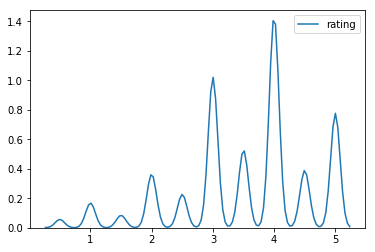

In [10]:
sns.kdeplot(ratings_dataset['rating'])

In [11]:
#Converting the format of Genre column to a list and then appending to the new list
Genre=[]
Genres={}
for num in range(0,len(movies_dataset)):
    key=movies_dataset.iloc[num]['title']
    value=movies_dataset.iloc[num]['genres'].split('|')
    Genres[key]=value
    Genre.append(value)

In [12]:
#Making a new column in our original Dataset         
movies_dataset['new'] =Genre

In [13]:
#Getting the year from the movie column 
p = re.compile(r"(?:\((\d{4})\))?\s*$")
years=[]
for movies in movies_dataset['title']:
     m = p.search(movies)
     year = m.group(1)
     years.append(year)  
movies_dataset['year']=years

In [14]:
#Deleting the year from the movies title column
movies_name=[]
raw=[]
for movies in movies_dataset['title']:
     m = p.search(movies)
     year = m.group(0)
     new=re.split(year,movies)
     raw.append(new)  
for i in range(len(raw)):
    movies_name.append(raw[i][0][:-2])

In [15]:
#Making a new column in the dataset having the movie name only in it 
movies_dataset['movie_name']=movies_name

In [16]:
#Converting the datatype of new column from list to string as required by the function
movies_dataset['new']=movies_dataset['new'].apply(' '.join)

In [17]:
 #Applying Feature extraction 
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
tfid=TfidfVectorizer(stop_words='english')
#matrix after applying the tfidf
matrix=tfid.fit_transform(movies_dataset['new'])


In [19]:
#Compute the cosine similarity of every genre
from sklearn.metrics.pairwise import cosine_similarity


In [20]:
cosine_sim=cosine_similarity(matrix,matrix)


In [21]:
#Making a new series which have two columns in it 
#Movie name and movie id 
movies_dataset = movies_dataset.reset_index()
titles = movies_dataset['movie_name']
indices = pd.Series(movies_dataset.index, index=movies_dataset['movie_name'])

In [40]:
#Function to make recommendation to the user
def recommendataion(movie):
    result=[]
    #Getting the id of the movie for which the user want recommendation
    ind=indices[movie]
    #Getting all the similar cosine score for that movie
    sim_scores=list(enumerate(cosine_sim[ind]))
    #Sorting the list obtained
    sim_scores=sorted(sim_scores,key=lambda x:x[1],reverse=True)    
    #Getting all the id of the movies that are related to the movie Entered by the user
    movie_id=[i[0] for i in sim_scores]    
    print('The Movie You Should Watched Next Are --')
    print('ID ,   Name ,  Average Ratings , Year ')
    #Varible to print only top 10 movies
    count=0
    for id in range(0,len(movie_id)):
      #to ensure that the movie entered by the user is doesnot come in his/her recommendation
        if(ind != movie_id[id]):
            ratings=ratings_dataset[ratings_dataset['movieId']==movie_id[id]]['rating']
            avg_ratings=round(np.mean(ratings),2)
            #To print only thoese movies which have an average ratings that is more than 3.5
            if(avg_ratings >3.5):
                count+=1
                print(f'{movie_id[id]} , {titles[movie_id[id]]} ,{avg_ratings}')
                result.append([titles[movie_id[id]],str(avg_ratings)])
            if(count >=10):
                    break
    
    print('Wait!! i am telling your recommendation')
    return result

In [24]:
#Converting the text to speech using google text to speech api
def text_to_speech():
    file = open('dd.txt','w')
    file.writelines(f'hello User \n')
    file.writelines('The Movie You Should Watched Next and their corresponding ratings are \n') 
    for res in result:
        res=' '.join(res)
        file.write(res+'\n')
        
    file.close()
    file = open('dd.txt','r')
    data= file.read()
    file.close()
    
    
    # Language in which you want to convert 
    language = 'en'
      
    # Passing the text and language to the engine,  
    # here we have marked slow=False. Which tells  
    # the module that the converted audio should  
    # have a high speed 
    myobj = gtts.gTTS(text=data, lang=language, slow=False) 
      
    # Saving the converted audio in a mp3 file named   
    i=random.randint(1,100)
    file='new'+str(i)+'.mp3'
    myobj.save(file) 
      
    #Playing the converted file 
    playsound(file)

In [30]:
#Making the method to get text from speech
import speech_recognition as sr

In [28]:
def speech_to_text():

    sample_rate = 48000

    chunk_size = 2048
    #Initialize the recognizer 
    r = sr.Recognizer() 

    with sr.Microphone(sample_rate = sample_rate,  
                            chunk_size = chunk_size) as source: 
        #wait for a second to let the recognizer adjust the  
        #energy threshold based on the surrounding noise level 
        r.adjust_for_ambient_noise(source) 
        print ("Speak the name of the movie ")
        #listens for the user's input 
        audio = r.listen(source) 

        try: 
            text = r.recognize_google(audio) 
            print(text)

        #error occurs when google could not understand what was said 

        except sr.UnknownValueError: 
            print("Google Speech Recognition could not understand audio") 

        except sr.RequestError as e: 
            print("Could not request results from Google  Speech Recognition service; {0}".format(e)) 
                
        return text

In [41]:
#Getting the output   
text=Speech_Recog.speech_to_text()
result=recommendataion(text)
text_to_speech()


Speak the name of the movie 
Yeh Jawaani Hai Deewani
The Movie You Should Watched Next Are --
ID ,   Name ,  Average Ratings , Year 
735 , My Fair Lady ,4.12
2571 , Pal Joey ,4.18
4537 , Sweet Charity ,4.25
4801 , Lagaan: Once Upon a Time in India ,4.5
720 , Singin' in the Rain ,4.0
728 , Gay Divorcee, The ,3.97
872 , Victor/Victoria ,5.0
1120 , Grease ,3.62
2302 , Pajama Game, The ,3.55
2929 , White Christmas ,3.89
Wait!! i am telling your recommendation
